<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Salvus</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Simulating wave propagation in layered media</div>
        </div>
    </div>
</div>

In [1]:
%matplotlib inline

# Import modules and setup paths.
import os
import h5py
import pyasdf
import matplotlib.pyplot as plt

PARAVIEW_BIN = os.environ["PARAVIEW_BIN"]
SALVUS_BIN = os.environ["SALVUS_BIN"]

all_rec_names = ['rec1', 'rec2', 'rec3', 'rec4', 'rec5']

In this example, we will simulate wave propagation through acoustic, elastic, and coupled media. By the end of the tutorial you should be able to generate a mesh, attach sources and receivers, generate simple movies, and run simulations in layered, coupled fluid / solid media. Let's get started!

### Generating the mesh

The first step is to generate a mesh approprate for the problem. These meshes can be generated from commerical meshing packages, such as Trelis, or with the Salvus ecosystem itself, using `salvus_meshser`. For this tutorial, we'll use Salvus' mesher to generate some simple layered models. Open the file up in your favourite text editor and check out the structure. These `.bm` mesher files make generating layered models a breeze. You can run the mesher in the box below by typing `python -m pymesher.interface`. Run it with `--help` to get information on the options. 

In this example, we'll mock a simple oceanic seismic survey. The `.bm` file specifies a model depth of about 4 km, and let's set the horizontal distance to 10 km. Since we're looking for something that can be run on a laptop, let's keep the mesh relatively small. With those dimensions, a mesh acurate to 10 Hz fulfils this criteria well. Of course, if you've got some beefier hardware, feel free to increase this frequency.

In [2]:
# Edit if necessary!
# !mousepad ACOUSTIC_LAYERED.bm

!python -m pymesher.interface Cartesian2D --basic.model ACOUSTIC_LAYERED.bm \
 --basic.period 0.1 --cartesian2D.x 0 10 --overwrite --output_filename acoustic_layered.e

Setting up background model and element sizes...
Creating the skeleton...
Creating the unstructured mesh...
attaching elastic parameters
Computing mesh quality...
Writing mesh to file...
SUMMARY OF MESH PROPERTIES:

  model name                       | ACOUSTIC_LAYERED
  dominant period input            |      0.10 s
  elements per wavelength          |      2.00
  Courant Number                   |      0.60

  resolved period (global max)     |      0.10 s
    location (z coordinate)        |      1.95 km
  resolved period (percentile 95)  |      0.10 s
  time step dt                     |    0.0087 s
    location (z coordinate)        |      2.55 km
  number of elements               |      2412
  number of points                 |      2536
  cost factor (nelem / dt)         |  2.76e+05

  max edge aspect ratio            |      2.68
  max equiangular skewness         |      0.59
GLOBAL VARIABLES:
  dt                         |   0.00874
  minimum_period             |   0.09976
ELE

Great. Now let's open it up in `Paraview`. You should see something similar to the figure below.

In [3]:
!$PARAVIEW_BIN acoustic_layered.e

![](images/acoustic_mesh_paraview.png)

Now, we'll leave you alone. See if you can generate some seismograms and visualize them here. Remember in this case we're in an acoustic medium! See if you can generate a nice movie, and get some receiver output. Let's run a simulation for 2 seconds.

In [4]:
!$SALVUS_BIN \
 --mesh-file acoustic_layered.e --model-file acoustic_layered.e \
 --polynomial-order 4 --dimension 2 --end-time 2.00 \
 --cmd-line-source --source-temporal-type ricker --source-spatial-type scalar \
 --source-location-x 6000 --source-location-y 3000 \
 --source-scale 1e10 --source-center-frequency 5.0 \
 --number-of-receivers 5 \
 --receiver-names XX.REC1,XX.REC2,XX.REC3,XX.REC4,XX.REC5 \
 --receiver-location-x 10,110,210,310,410 \
 --receiver-location-y 1800,1800,1800,1800,1800 \
 --receiver-file-name receivers.h5 \
 --receiver-fields u_ACOUSTIC \
 --receiver-medium fluid,fluid,fluid,fluid,fluid \
 --absorbing-boundaries x0,x1,y0 \
 --save-movie --movie-file-name movie.h5 --movie-fields u_ACOUSTIC


Salvus version 0.0.1-974-g7237b8b
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

--source-time-delay not set. Will auto-calculate.
Initializing problem.
Start time set to -0.311879.
Time step set to: 0.000748214 s.
Start time set to -0.311879.
Begin time loop.
Time loop progress [100%].
Time loop completed in 12.1182 seconds.
Begin post processing.
Problem complete.



In [5]:
!python petsc_gen_xdmf.py movie.h5
!$PARAVIEW_BIN ./movie.xmf

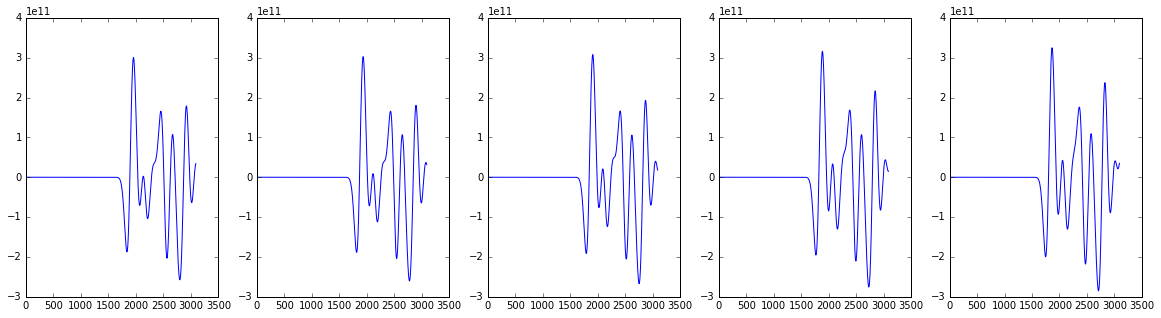

In [6]:
def plot_hdf5_seismograms(asdf_file, axes, mode):
    if mode == 'acoustic':
        par_map = ['A']
    elif mode == 'elastic':    
        par_map = ['X', 'Y']
    else:
        raise ValueError("Incorret mode specified.")
        
    flat_axes = axes.flatten()
    for i, waveform in enumerate(asdf_file.waveforms):
        for j in range(len(par_map)):
            axes[i+j*len(par_map)].plot(
                waveform.displacement.select(component=par_map[j])[0].data)
            
fig, axes = plt.subplots(1, 5, sharex='row', sharey='col', figsize=(20,5))
with pyasdf.ASDFDataSet("receivers.h5") as ds:           
    plot_hdf5_seismograms(ds, axes, 'acoustic')

### Switching to elastic media
Let's up the complexity of our simulation a bit, and add a simulation using elastic media. Use a Poisson's ratio of 0.25 to generate non-zero VS values from your chosen VP values. Write a python function to transform the values in your VP column to VS.

In [7]:
# Generating the VS values.
def VP_to_VS(VP):
    """Take a VP value and return VS."""
    ratio = 0.25
    VS = ((1 - 2 * ratio) / (2 * (1 - ratio))) * VP
    return VS

VS = [VP_to_VS(V) for V in [1.5e3, 1.5e3, 2.7e3, 3.0e4,
                            3.9e3, 5.0e3, 5.5e3, 6.0e3, 6.2e3]]
print("S-wave velocities: ", VS)

S-wave velocities:  [500.0, 500.0, 900.0, 10000.0, 1300.0, 1666.6666666666665, 1833.3333333333333, 2000.0, 2066.6666666666665]


Now, use the command line functionality of the mesher to generate an elastic mesh with these new values. As well, let's open it up in Paraview to see what it looks like.

In [8]:
# Generating the elastic mesh.
# Edit if required.
# !mousepad ELASTIC_LAYERED.bm 
! python -m pymesher.interface Cartesian2D --basic.model ELASTIC_LAYERED.bm \
 --basic.period 0.1 --cartesian2D.x 0 10 \
 --overwrite --output_filename elastic_layered.e

Setting up background model and element sizes...
Creating the skeleton...
Creating the unstructured mesh...
attaching elastic parameters
Computing mesh quality...
Writing mesh to file...
SUMMARY OF MESH PROPERTIES:

  model name                       | ELASTIC_LAYERED
  dominant period input            |      0.10 s
  elements per wavelength          |      2.00
  Courant Number                   |      0.60

  resolved period (global max)     |      0.10 s
    location (z coordinate)        |      3.81 km
  resolved period (percentile 95)  |      0.10 s
  time step dt                     |    0.0030 s
    location (z coordinate)        |      2.64 km
  number of elements               |     17900
  number of points                 |     18216
  cost factor (nelem / dt)         |  6.02e+06

  max edge aspect ratio            |      3.00
  max equiangular skewness         |      0.63
GLOBAL VARIABLES:
  dt                         |   0.00297
  minimum_period             |   0.10000
ELEM

In [9]:
# View in paraview.
!$PARAVIEW_BIN ./elastic_layered.e

**What do you notice is different about the mesh?** 

Remember what is happening here. To be accurate at 4th order, Salvus requires a mesh with 2 elements per minimum wavelength. Since the shear-wave velocity is now so much smaller, the elements must be made smaller to compensate. Thus, there are many more elements in this mesh than the equivalent acoustic one. _As well_ since the elements are smaller, the timestep must be reduced to remain stable. All in all **an elastic simulation can be hundreds of times more expensive than an equivalent acoustic-only simulation**. It is no wonder why most of exploration seismology is done under the acoustic approximation!

If you have decent hardware, a 0.5 second elastic simulation should take just over 3 minutes on one core. Depending on how well your virtualbox supports `MPI`, you can speed this up by specifying `mpirun -n 2`. Of course, if we were on a cluster, we could specify `mpirun -n N`, with `N` as large as we can support. Alternatively, you can reduce the resolution of the mesh to generate less elements. Don't forget to adjust the center frequency of your source as well!

In [10]:
# Running the elastic simulation
# This is a very short simulation for speed reasons. If you can spare a
# minute or two, make the end-time larger (1.0 seconds or more).
!$SALVUS_BIN \
 --mesh-file elastic_layered.e --model-file elastic_layered.e \
 --polynomial-order 4 --dimension 2 --end-time 0.01 \
 --cmd-line-source \
 --source-temporal-type ricker --source-spatial-type moment_tensor \
 --source-location-x 6000 --source-location-y 3000 \
 --source-scale 1e10,1e10,0 --source-center-frequency 5.0 --number-of-receivers 5 \
 --receiver-names rec1,rec2,rec3,rec4,rec5 --receiver-location-x 10,110,210,310,410 \
 --receiver-location-y 1800,1800,1800,1800,1800 \
 --receiver-file-name receivers.h5 --receiver-fields u_ELASTIC \
 --receiver-medium solid,solid,solid,solid,solid --absorbing-boundaries x0,x1,y0 \
 --save-movie --movie-file-name movie.h5 --movie-fields u_ELASTIC --save-frame-every 100


Salvus version 0.0.1-974-g7237b8b
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

--source-time-delay not set. Will auto-calculate.
Initializing problem.
Start time set to -0.311879.
Time step set to: 0.000255812 s.
Start time set to -0.311879.
Begin time loop.
Time loop progress [100%].
Time loop completed in 62.6133 seconds.
Begin post processing.
Problem complete.



### Switching to coupled acoustic / elastic media

To really get the physics correct in this example, we'll want to work with a coupled domain. The topmost layer we will treat as an ocean, while the rest of the problem will still be elastic. To generate this mesh, you simply need to specify `VS = 0.0` in the top layer of the model file. Make sure you set it to `0.0` at both the top and bottom of the discontinuity, otherwise you will have a gradient in S-wave velocity, and the mesher cannot assume that the element is fluid.

If the mesh is generated with fluid and solid elements, Salvus with use PETSc's DMPLEX package to explore the Hasse Diagram for each element, and automatically determine which edges lie along coupling boundaries. No need to specify these manually!

In [11]:
# Generating the elastic mesh.
# Edit if necessary
# !mousepad COUPLED_LAYERED.bm
!python -m pymesher.interface Cartesian2D --basic.model COUPLED_LAYERED.bm \
 --basic.period 0.1 --cartesian2D.x 0 10 --overwrite --output_filename coupled_layered.e

Setting up background model and element sizes...
Creating the skeleton...
Creating the unstructured mesh...
attaching elastic parameters
Computing mesh quality...
Writing mesh to file...
SUMMARY OF MESH PROPERTIES:

  model name                       | COUPLED_LAYERED
  dominant period input            |      0.10 s
  elements per wavelength          |      2.00
  Courant Number                   |      0.60

  resolved period (global max)     |      0.10 s
    location (z coordinate)        |      2.06 km
  resolved period (percentile 95)  |      0.10 s
  time step dt                     |    0.0045 s
    location (z coordinate)        |      2.03 km
  number of elements               |     10640
  number of points                 |     10867
  cost factor (nelem / dt)         |  2.39e+06

  max edge aspect ratio            |      2.24
  max equiangular skewness         |      0.54
GLOBAL VARIABLES:
  dt                         |   0.00446
  minimum_period             |   0.09995
ELEM

In [12]:
# View in paraview.
!$PARAVIEW_BIN coupled_layered.e

In [13]:
# Running the elastic simulation

# This is a very short simulation for speed reasons. If you can spare a
# minute or two, make the end-time larger (1.0 seconds or more).
!$SALVUS_BIN --mesh-file coupled_layered.e --model-file coupled_layered.e \
 --polynomial-order 4 --dimension 2 --end-time 0.02 --cmd-line-source \
 --source-temporal-type ricker --source-spatial-type scalar \
 --source-location-x 6000 --source-location-y 4000 \
 --source-scale 1e10,1e10,0 --source-center-frequency 5.0 \
 --number-of-receivers 5 \
 --receiver-names XX.REC1,XX.REC2,XX.REC3,XX.REC4,XX.REC5 \
 --receiver-location-x 10,110,210,310,410 --receiver-location-y 1700,1700,1700,1700,1700 \
 --receiver-file-name receivers.h5 --receiver-fields u_ELASTIC \
 --receiver-medium solid,solid,solid,solid,solid\
 --absorbing-boundaries x0,x1,y0 \
 --save-movie --movie-file-name movie.h5 --movie-fields u_ELASTIC \
 --save-frame-every 100 


Salvus version 0.0.1-974-g7237b8b
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

--source-time-delay not set. Will auto-calculate.
Initializing problem.
Start time set to -0.311879.
Time step set to: 0.000384818 s.
Start time set to -0.311879.
Begin time loop.
Time loop progress [100%].
Time loop completed in 30.2245 seconds.
Begin post processing.
Problem complete.



Check out what the movie looks like, and feel free to play around a bit more. With the API of the mesher you can make models with topography, and curved fluid solid boundaries, but the workflow remains the same.